In [1]:
from google.colab import drive
drive.mount('/content/drive/')

! mkdir ~/.kaggle

Mounted at /content/drive/


In [2]:
! cp /content/drive/MyDrive/kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/breast-histopathology-images

! unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [3]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import gc

In [4]:
from glob import glob
data = glob('IDC_regular_ps50_idx5/**/*.png', recursive = True)
data_0 = glob('IDC_regular_ps50_idx5/*/0/*.png', recursive = True)
data_1 = glob('IDC_regular_ps50_idx5/*/1/*.png', recursive = True)

In [5]:
import random

def randomSamples(imageData):
    lst = list()
    while(len(lst) != 25000):
        a = random.choice(imageData)

        if a not in lst:
            lst.append(a)

    return lst

In [6]:
img_size = 64

In [7]:
import cv2
import matplotlib.pyplot as plt

images = list()
labels = list()
newData = list()

# newData = randomSamples(data)
newData_0 = randomSamples(data_0)
newData_1 = randomSamples(data_1)

for i in newData_0:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2GRAY)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

for i in newData_1:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2GRAY)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

In [8]:
len(images)

50000

In [9]:
images_array = np.array(images)

In [10]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images_array, y, random_state = 42, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 42, test_size = 0.3)

In [12]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], img_size, img_size, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(x_train)
test_images = preprocess_images(x_test)
val_images = preprocess_images(x_val)

In [13]:
print('len(x_train):', len(train_images))
print('len(x_test):', len(test_images))
print('len(x_val):', len(val_images))
print('len(y_train):', len(y_train))
print('len(y_test):', len(y_test))
print('len(y_val):', len(y_val))

len(x_train): 28000
len(x_test): 10000
len(x_val): 12000
len(y_train): 28000
len(y_test): 10000
len(y_val): 12000


In [14]:
import tensorflow as tf

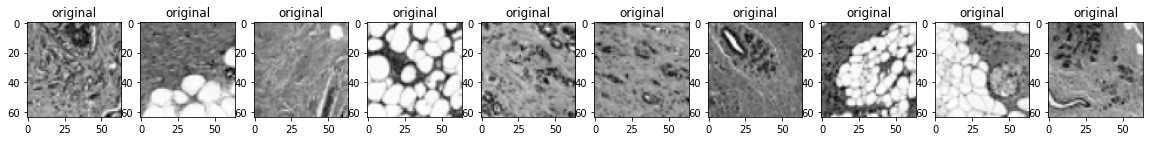

In [15]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

# Building the Neural Network

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import models, layers

In [17]:
import tensorflow as tf

In [ ]:
def nn_model():
    model = models.Sequential()
    model.add(EfficientNetB3(include_top = False, weights = None, input_shape = (img_size, img_size, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(2, activation = 'softmax'))

    return model

model = nn_model()
model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training the model

In [19]:
cnn = Sequential(
    [
      layers.InputLayer(input_shape = (img_size, img_size, 1)),
      layers.Conv2D(filters = 64, kernel_size = 3, strides = (2, 2), activation = 'relu'),
      layers.Conv2D(filters = 128, kernel_size = 3, strides = (2, 2), activation = 'relu'),
      layers.MaxPool2D(),
      layers.Dropout(0.2),
      layers.Conv2D(filters = 256, kernel_size = 3, strides = (2, 2), activation = 'relu'),
      layers.MaxPool2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(2, activation = 'sigmoid')
    ]
)

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                  

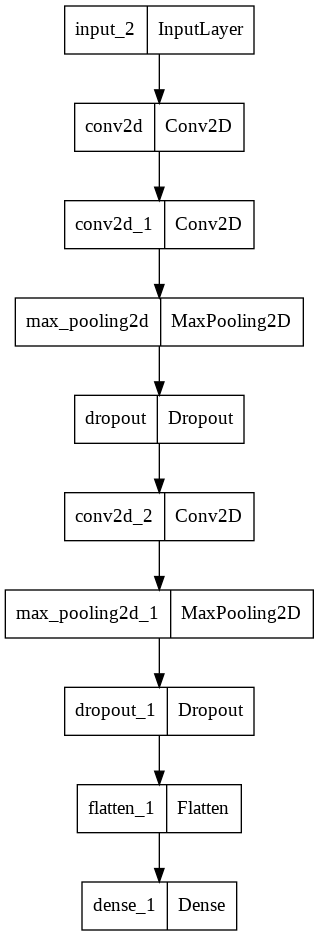

In [20]:
tf.keras.utils.plot_model(cnn)

In [21]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.0005)
m = [
    'acc', 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall(), 
    tf.keras.metrics.AUC()
    ]
cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = m)

In [22]:
with tf.device('/gpu:0'):
  new_history = cnn.fit(
      train_images, y_train, epochs = 25, batch_size = 32, validation_data = (val_images, y_val)
  )

Epoch 1/25
875/875 [==============================] - 16s 8ms/step - loss: 0.5912 - acc: 0.6987 - precision: 0.6864 - recall: 0.7288 - auc: 0.7489 - val_loss: 0.5769 - val_acc: 0.7094 - val_precision: 0.7025 - val_recall: 0.7252 - val_auc: 0.7698
Epoch 2/25
875/875 [==============================] - 6s 7ms/step - loss: 0.5663 - acc: 0.7243 - precision: 0.7077 - recall: 0.7537 - auc: 0.7759 - val_loss: 0.5685 - val_acc: 0.7159 - val_precision: 0.7001 - val_recall: 0.7484 - val_auc: 0.7789
Epoch 3/25
875/875 [==============================] - 6s 7ms/step - loss: 0.5526 - acc: 0.7330 - precision: 0.7145 - recall: 0.7663 - auc: 0.7894 - val_loss: 0.5629 - val_acc: 0.7207 - val_precision: 0.6980 - val_recall: 0.7649 - val_auc: 0.7822
Epoch 4/25
875/875 [==============================] - 6s 7ms/step - loss: 0.5427 - acc: 0.7368 - precision: 0.7127 - recall: 0.7825 - auc: 0.7969 - val_loss: 0.5717 - val_acc: 0.7163 - val_precision: 0.6905 - val_recall: 0.7582 - val_auc: 0.7732
Epoch 5/25
875/

In [23]:
import tensorflow as tf

# Reduce learing rate if the learning seems to have become constant

rlronp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    mode = 'min',
    min_lr = 1e-6,
    patience = 2,
    verbose = 1
    )

estop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 3, 
    verbose = 1,
    restore_best_weights = True
)

In [ ]:
with tf.device('/gpu:0'):
  history_with_callbacks = cnn.fit(
      train_images,
      y_train,
      epochs = 25,
      validation_data = (val_images, y_val),
      callbacks = [rlronp, estop]
  )

Epoch 1/25
440/440 [==============================] - 42s 92ms/step - loss: 0.2207 - accuracy: 0.9120 - val_loss: 0.4950 - val_accuracy: 0.7694 - lr: 1.0000e-05
Epoch 2/25
440/440 [==============================] - 40s 91ms/step - loss: 0.1997 - accuracy: 0.9237 - val_loss: 0.4470 - val_accuracy: 0.8244 - lr: 1.0000e-05
Epoch 3/25
440/440 [==============================] - 38s 87ms/step - loss: 0.1998 - accuracy: 0.9222 - val_loss: 0.4767 - val_accuracy: 0.8006 - lr: 1.0000e-05
Epoch 4/25
440/440 [==============================] - 40s 91ms/step - loss: 0.1821 - accuracy: 0.9317 - val_loss: 0.4070 - val_accuracy: 0.8355 - lr: 1.0000e-05
Epoch 5/25
440/440 [==============================] - 38s 87ms/step - loss: 0.1729 - accuracy: 0.9337 - val_loss: 0.4139 - val_accuracy: 0.8368 - lr: 1.0000e-05
Epoch 6/25
440/440 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9384
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
440/440 [=============

# Evaluating the model

In [24]:
loss, accuracy, precision, recall, auc = cnn.evaluate(test_images, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.9449 - acc: 0.6876 - precision: 0.6805 - recall: 0.6984 - auc: 0.7271


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

In [42]:
# Save the model
cnn.save('drive_before_VAE.h5')
# new_model = tensorflow.keras.models.load_model('before.h5')
# new_model.summary()

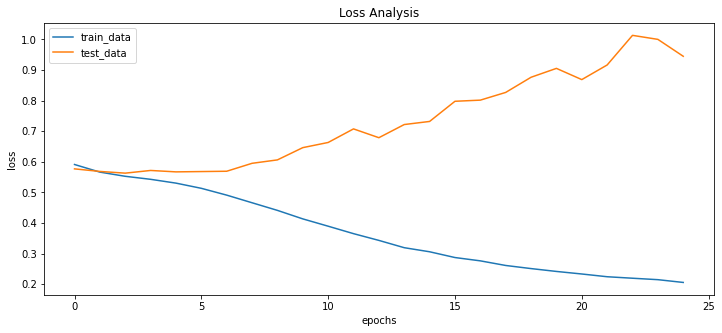

In [25]:
plt.figure(figsize = (12, 5))
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

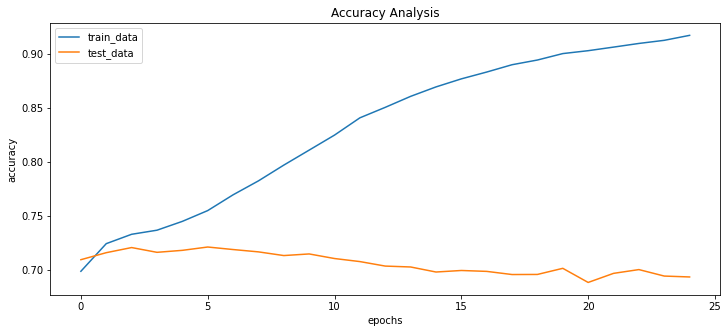

In [26]:
plt.figure(figsize = (12, 5))
plt.plot(new_history.history['acc'])
plt.plot(new_history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()

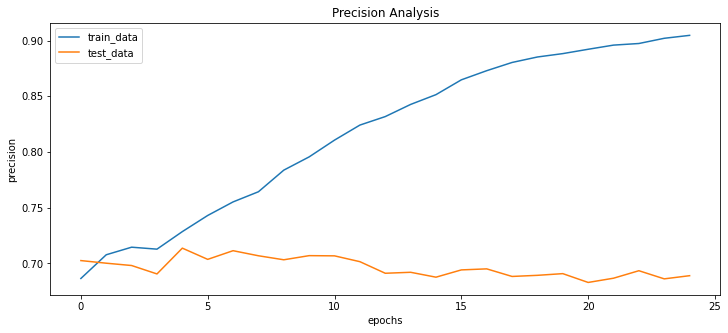

In [40]:
plt.figure(figsize = (12, 5))
plt.plot(new_history.history['precision'])
plt.plot(new_history.history['val_precision'])
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend(['train_data', 'test_data'])
plt.title('Precision Analysis')
plt.show()

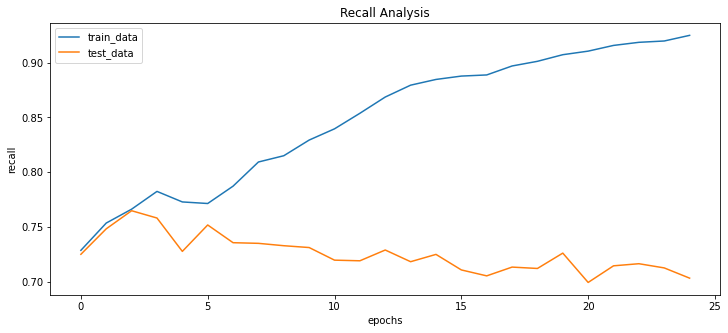

In [41]:
plt.figure(figsize = (12, 5))
plt.plot(new_history.history['recall'])
plt.plot(new_history.history['val_recall'])
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend(['train_data', 'test_data'])
plt.title('Recall Analysis')
plt.show()

In [13]:
# Loading the model
from tensorflow import keras
NN_model = keras.models.load_model('/content/drive/MyDrive/Local_Backup/Codes_WSL/drive_before_VAE.h5')

# saved_model = tensorflow.keras.models.load_model('VAE.h5')

# Statistical Analysis

In [29]:
y_pred = np.argmax(cnn.predict(test_images), axis = 1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 2s 5ms/step


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
cm = confusion_matrix(y_true,y_pred)
print(cm)

[[3697 1325]
 [1799 3179]]


In [31]:
target_names=['IDC Positive (1)', 'IDC Negative (0)']
print(classification_report(y_true, y_pred, target_names = target_names, digits=2))

                  precision    recall  f1-score   support

IDC Positive (1)       0.67      0.74      0.70      5022
IDC Negative (0)       0.71      0.64      0.67      4978

        accuracy                           0.69     10000
       macro avg       0.69      0.69      0.69     10000
    weighted avg       0.69      0.69      0.69     10000



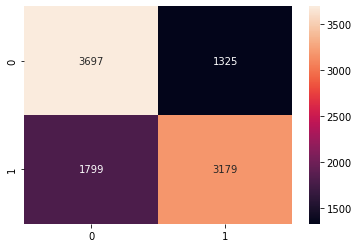

In [32]:
import seaborn as sns
f = sns.heatmap(cm, annot=True, fmt='d')  #confusion matrix plot

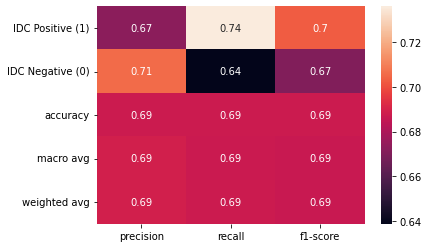

In [33]:
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, target_names = target_names, output_dict = True)).iloc[:-1, :].T, annot=True)  

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, roc_auc_score, plot_confusion_matrix, classification_report

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred, average = 'weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred, average = 'weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred, average = 'weighted')
print('F1 score: %f' % f1)

Accuracy: 0.687600
Precision: 0.689171
Recall: 0.687600
F1 score: 0.686831


In [35]:
   # kappa
kappa = cohen_kappa_score(y_true, y_pred)
print('Cohens kappa: %f' % kappa)
    # ROC AUC
auc = roc_auc_score(y_test, cnn.predict(test_images))
print('ROC AUC: %f' % auc)

Cohens kappa: 0.374927
313/313 [==============================] - 1s 5ms/step
ROC AUC: 0.720956


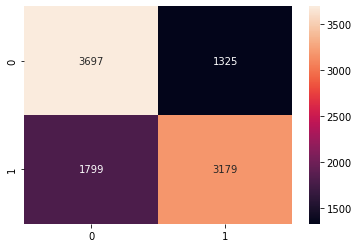

In [36]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_true, y_pred)
f = sns.heatmap(cnf_matrix, annot=True, fmt='d')

In [37]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [38]:
print(f'FP: {FP}' )
print(f'FN: {FN}' )
print(f'TP: {TP}' )
print(f'TN: {TN}' )

FP: [1799. 1325.]
FN: [1325. 1799.]
TP: [3697. 3179.]
TN: [3179. 3697.]


In [39]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
my_formatted_TPR = [ '%.2f' % elem for elem in TPR ]
print(f'Sensitivity: {my_formatted_TPR}') 

# Specificity or true negative rate
TNR = TN/(TN+FP) 
my_formatted_TNR = [ '%.2f' % elem for elem in TNR ]
print(f'Specificity: {my_formatted_TNR}') 

# Precision or positive predictive value
PPV = TP/(TP+FP)
my_formatted_PPV = [ '%.2f' % elem for elem in PPV ]
print(f'Precision: {my_formatted_PPV}') 
# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
my_formatted_ACC = [ '%.2f' % elem for elem in ACC ]
print(f'accuracy: {my_formatted_ACC}')

F1 = 2 * (PPV * TPR) / (PPV + TPR)
my_formatted_F1 = [ '%.2f' % elem for elem in F1 ]
print(f'F1 Score: {my_formatted_F1}') 

num_classes = 2

print("-"*40)
sens=TPR.sum()/num_classes
spec=TNR.sum()/num_classes
f1=F1.sum()/num_classes
print(f'Sensitivity/Recall: {round(sens,2)}'  )
print(f'Specificity: {round(spec,2)}' )
print(f'F1 score: {round(f1,2)}' )

Sensitivity: ['0.74', '0.64']
Specificity: ['0.64', '0.74']
Precision: ['0.67', '0.71']
accuracy: ['0.69', '0.69']
F1 Score: ['0.70', '0.67']
----------------------------------------
Sensitivity/Recall: 0.69
Specificity: 0.69
F1 score: 0.69
